# Wright-Fisher Simulator
#### Chris Porras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
%matplotlib inline

### WF simulator for a single deme
Simulates allele frequency changes in a haploid population of size N based on a Wright-Fisher model with the following parameters:<br>
    $s$ is the selection coefficient or selection rate for purifying selection <br>
    $\mu$ is the mutation rate

In [2]:
def WF_sim(N,mu,s,num_reps,num_gen,p0):
    f = np.zeros((num_gen+1,num_reps))
    f[0] = [p0]*num_reps
    for j in range(num_gen):
        p = f[j]+mu*(1-2*f[j])-s*f[j]*(1-f[j])
        f[j+1]= np.random.binomial(N,p)/N
    return f

In [3]:
# Define parameters for single deme
s = 10**-2 # selection rate
N = 10**3 # population size
mu = 10**-4 # mutation rate
num_reps = 100 # number of independent sites simulated
num_gen = 2* 10**3 # number of simulation generations
p0 = 0.1 # initial allele frequency

In [4]:
f = WF_sim(N,mu,s,num_reps,num_gen,p0)

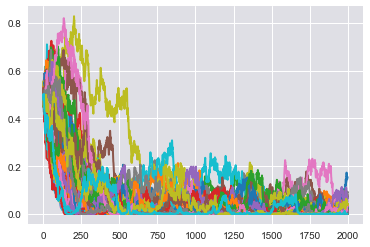

In [10]:
plt.plot(f)
plt.show()

### WF Simulator with stepping stone migration
Introduces migration as per the Kimura stepping stone model. Simulates a 1D ring of demes, or subpopulations connected by a symmettric migration rate $m$.

In [5]:
def SS_WF_sim(N,mu,s,m,num_reps,num_gen,num_demes,p0):
    f = np.zeros((num_gen+1,num_reps,num_demes))
    f[0] = np.repeat(np.repeat(p0,num_reps),
                     num_demes).reshape(num_reps,num_demes)
    for j in range(num_gen):
        for i in range(num_demes):
            if (i+1) >= num_demes:
                i = i - num_demes
            df = mu*(1-2*f[j,:,i])-s*f[j,:,i]*(1-f[j,:,i])+m*(f[j,:,i-1]+f[j,:,i+1]-2*f[j,:,i])
            p = f[j,:,i] + df
            p[np.where(np.array(p) < 0)] =0
            p[np.where(np.array(p) > 1)] =1
            f[j+1,:,i]= np.random.binomial(N,p)/N
    return f

In [133]:
# Define parameters for 1D chain of demes
s = 10**-2 # selection rate
N = 10**3 # population size
mu = 10**-4 # mutation rate
m = 0.1 # migration rate
num_demes = 50 # number of demes simulated
num_reps = 1000 # number of independent sites simulated
num_gen = 10**4 # number of simulation generations
p0 = 0.1 # initial allele frequency

In [134]:
f = SS_WF_sim(N,mu,s,m,num_reps,num_gen,num_demes,p0)

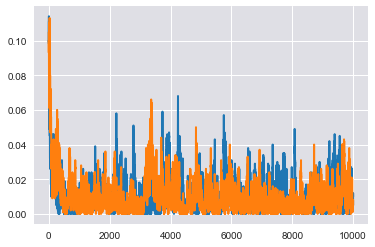

In [135]:
plt.plot(f[:,0,0])
plt.plot(f[:,0,30])

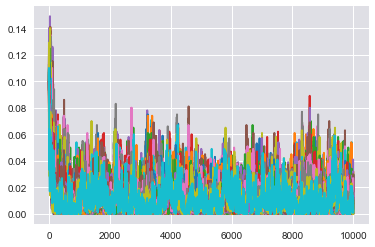

In [137]:
for r in range(num_demes):
    plt.plot(f[:,0,r])
plt.show()

### Reconstruct genotype matrix from frequencies for each site and each deme

In [138]:
def make_GT_arr(f):    
    eq_f = f[-1] # choose frequencies at equilibrium
    alleles = [0,1] # 0 for REF and 1 for ALT
    GT = np.zeros((num_reps,N*num_demes))
    genotypes = np.zeros(N*num_demes)
    for i in range(N):
        for j in range(num_demes):
            probs = [eq_f[i,j],1-eq_f[i,j]]
            genotypes[(N*j):(N*(j+1))] = np.random.choice(alleles,size=N,p=probs)
        GT[i] = genotypes
    return GT

In [112]:
GT = make_GT_arr(f)

In [115]:
f[-1].shape

(1000, 50)

### Perform PCA with sklearn

In [139]:
# Standardize data
prep_f = (f[-1] - np.mean(f[-1],axis=1)[:,None])/(np.std(f[-1],axis=1) + np.finfo(float).eps)[:,None]

In [140]:
prep_f.shape

(1000, 50)

In [141]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
PCs = pca.fit_transform(prep_f)

In [142]:
print(pca.explained_variance_ratio_)

[0.11414795 0.10480352 0.08236431]


## PCA Plots below 
> Messy, unoptimized cells incoming

Text(0.5,0.92,'WF_SS_Sim')

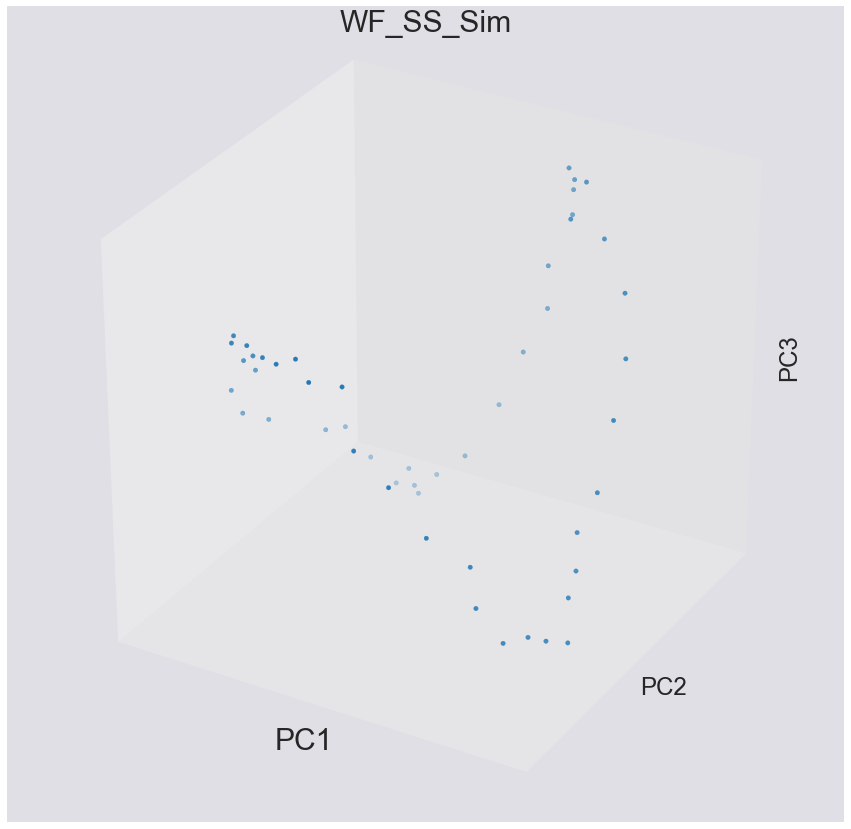

In [143]:
from mpl_toolkits import mplot3d
Matrix = prep_f

PC1 = Matrix.T@PCs[:, 0]
PC2 = Matrix.T@PCs[:, 1]
PC3 = Matrix.T@PCs[:, 2]

fig = plt.figure(figsize=(15,15))
plot_name = "WF_SS_Sim"

ax = plt.axes(projection ='3d')

ax.scatter3D(PC1,PC2,PC3)

ax.set_xlabel('PC1', fontsize=30)
ax.set_xticks([])
ax.set_ylabel('PC2',fontsize=24)
ax.set_yticks([])
ax.set_zlabel(r'PC3', fontsize=24,rotation = 90)
ax.set_zticks([])
ax.set_title(plot_name, fontsize=30,pad = 40)


In [144]:
PC1.shape

(50,)

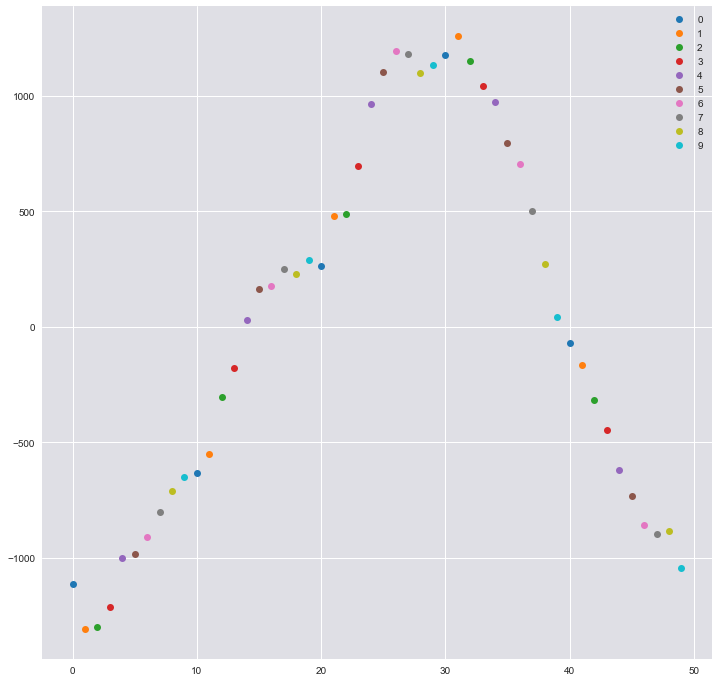

In [145]:
plt.figure(figsize=(12,12))
labels = np.arange(10)
for i in range(len(PC2)):
    if i in labels:
        mylabel = str(labels[i])
    else:
        mylabel = None
    plt.plot(np.arange(num_demes)[i],PC1[i],"o",label = mylabel)
# plt.xlabel('PC2')
# plt.xticks([])
# plt.ylabel(ylabel ="PC3")
# plt.yticks([])
plt.legend(loc = "upper right")
plt.savefig("WFsim_x_PC1.png",quality = 95)
plt.show()  

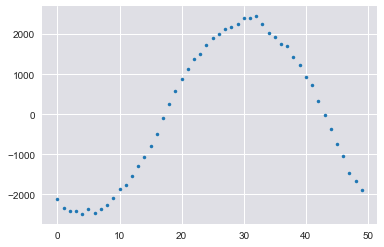

In [124]:
plt.plot(np.arange(num_demes),PC1,".")

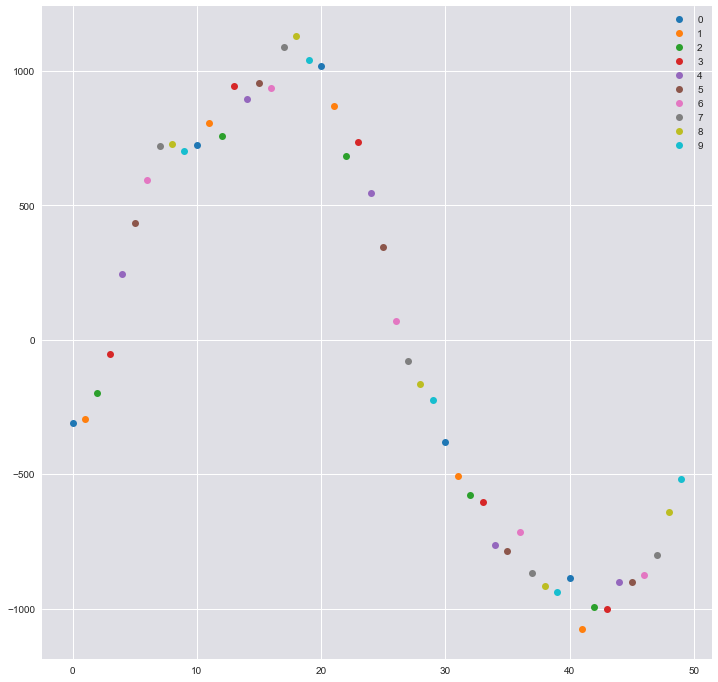

In [146]:
plt.figure(figsize=(12,12))
labels = np.arange(10)
for i in range(len(PC2)):
    if i in labels:
        mylabel = str(labels[i])
    else:
        mylabel = None
    plt.plot(np.arange(num_demes)[i],PC2[i],"o",label = mylabel)
# plt.xlabel('PC2')
# plt.xticks([])
# plt.ylabel(ylabel ="PC3")
# plt.yticks([])
plt.legend(loc = "upper right")
plt.savefig("WFsim_x_PC2.jpg")
plt.show()  

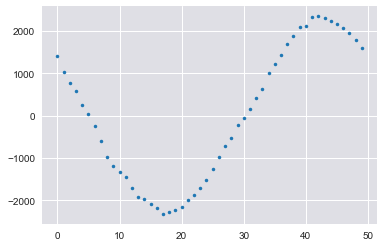

In [127]:
plt.plot(np.arange(num_demes),PC2,".")

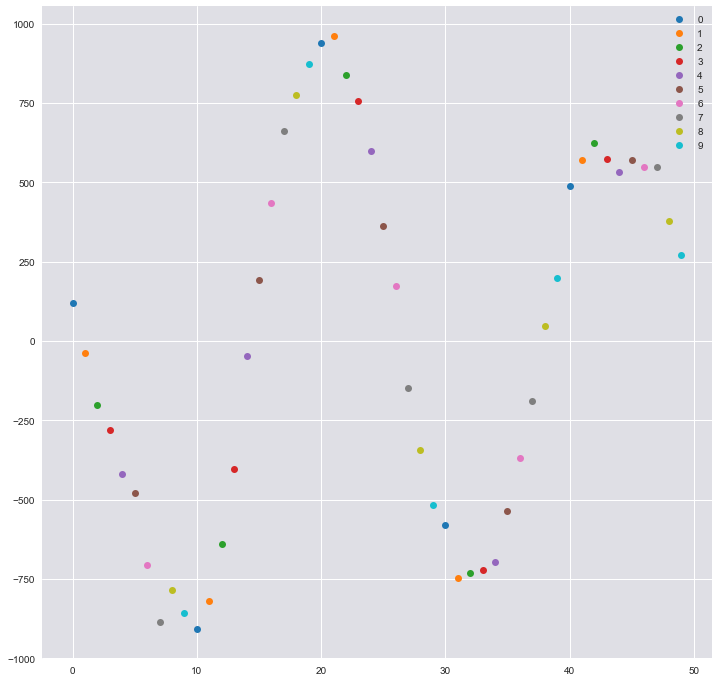

In [147]:
plt.figure(figsize=(12,12))
labels = np.arange(10)
for i in range(len(PC2)):
    if i in labels:
        mylabel = str(labels[i])
    else:
        mylabel = None
    plt.plot(np.arange(num_demes)[i],PC3[i],"o",label = mylabel)
# plt.xlabel('PC2')
# plt.xticks([])
# plt.ylabel(ylabel ="PC3")
# plt.yticks([])
plt.legend(loc = "upper right")
plt.savefig("WFsim_x_PC3.jpg")
plt.show()  

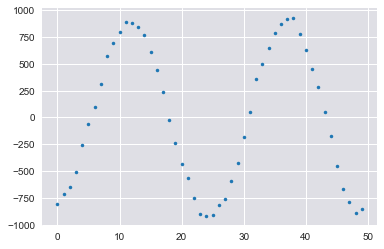

In [129]:
plt.plot(np.arange(num_demes),PC3,".")

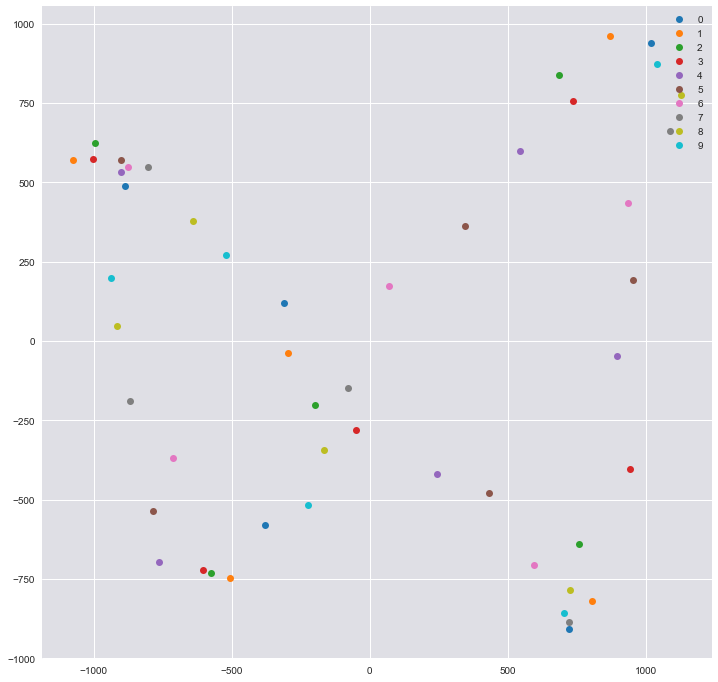

In [148]:
plt.figure(figsize=(12,12))
labels = np.arange(10)
for i in range(len(PC2)):
    if i in labels:
        mylabel = str(labels[i])
    else:
        mylabel = None
    plt.plot(PC2[i],PC3[i],"o",label = mylabel)
# plt.xlabel('PC2')
# plt.xticks([])
# plt.ylabel(ylabel ="PC3")
# plt.yticks([])
plt.legend(loc = "upper right")
plt.savefig("WFsim_PC2_PC3.jpg")

plt.show()    



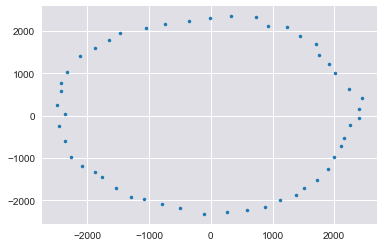

In [131]:
plt.plot(PC1,PC2,".")

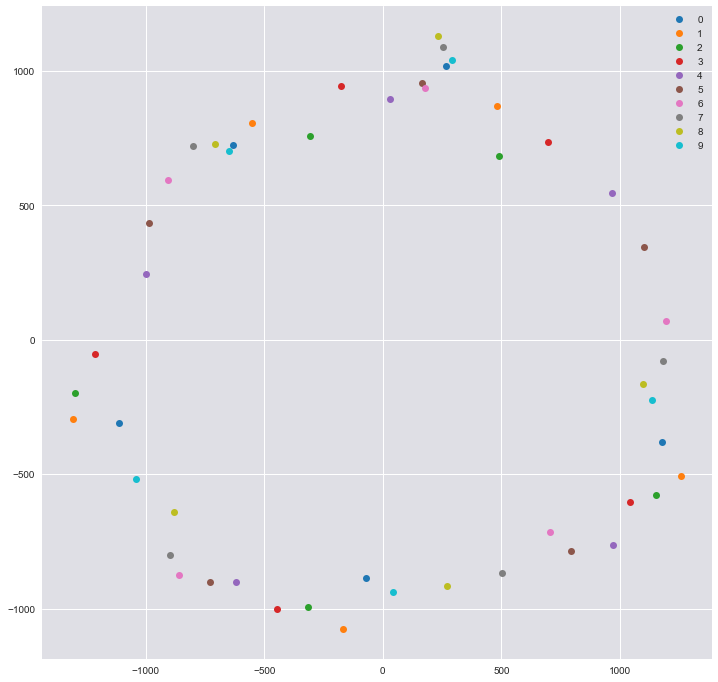

In [149]:
plt.figure(figsize=(12,12))
labels = np.arange(10)
for i in range(len(PC2)):
    if i in labels:
        mylabel = str(labels[i])
    else:
        mylabel = None
    plt.plot(PC1[i],PC2[i],"o",label = mylabel)
# plt.xlabel('PC2')
# plt.xticks([])
# plt.ylabel(ylabel ="PC3")
# plt.yticks([])
plt.legend(loc = "upper right")
plt.savefig("WFsim_PC1_PC2.jpg")

plt.show()    



### TEST

In [86]:
from sklearn.decomposition import PCA

In [87]:
# Define parameters for 1D chain of demes
s = 0 # selection rate
N = 10**3 # population size
mu = 10**-4 # mutation rate
num_demes = 50 # number of demes simulated
num_reps = 1000 # number of independent sites simulated
num_gen = 5* 10**3 # number of simulation generations
p0 = 0.5 # initial allele frequency

m_arr = [.5,1,5]


for q in range(len(m_arr)):
    m = m_arr[q]

    f = SS_WF_sim(N,mu,s,m,num_reps,num_gen,num_demes,p0)

    prep_f = (f[-1] - np.mean(f[-1],axis=0))/np.std(f[-1],axis=0)

    pca = PCA(n_components=3)
    PCs = pca.fit_transform(prep_f)

    PC1 = prep_f.T@PCs[:, 0]
    PC2 = prep_f.T@PCs[:, 1]
    PC3 = prep_f.T@PCs[:, 2]
    
    plt.figure(figsize=(12,12))
    
    labels = np.arange(10)
    for i in range(len(PC2)):
        if i in labels:
            mylabel = str(labels[i])
        else:
            mylabel = None
        plt.plot(PC2[i],PC3[i],"o",label = mylabel)
        
    plt.legend(loc = "upper right")
    plt.savefig(f"WFsim_PC2_PC3_m_{m}.jpg")

    plt.show()  
    
    plt.figure(figsize=(12,12))
    
    labels = np.arange(10)
    for i in range(len(PC1)):
        if i in labels:
            mylabel = str(labels[i])
        else:
            mylabel = None
        plt.plot(np.arange(num_demes)[i],PC2[i],"o",label = mylabel)
        
    plt.legend(loc = "upper right")
    plt.savefig(f"WFsim_x_PC2_m_{m}.jpg")

    plt.show()    

KeyboardInterrupt: 

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
PCs.shape